In [1]:
import torch
import torch.nn as nn
from torch.backends import cudnn

from torchvision import transforms, models
from movieframe_dataset import MovieFrameDataset
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Transforming the data
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [3]:
# Creating the dataset and the data loaders
dataset = MovieFrameDataset(r'D:\frames', multilabel=False, transform=transform)
category_names = dataset.categories

# train_set, test_set = torch.utils.data.random_split(dataset, [40000, len(dataset)-40000])

indices = np.arange(len(dataset))
indices = np.random.permutation(indices)

subset = Subset(dataset, indices[:5000])

train_set, test_set = torch.utils.data.random_split(subset, [4000, 1000])

print('train_set:', len(train_set))
print('test_set:', len(test_set))

train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)

train_set: 4000
test_set: 1000


Label: [18  4  2  0  4  0  8 14  0 18]
Category: Animation Drama Comedy Action Drama Action Horror Biography Action Animation



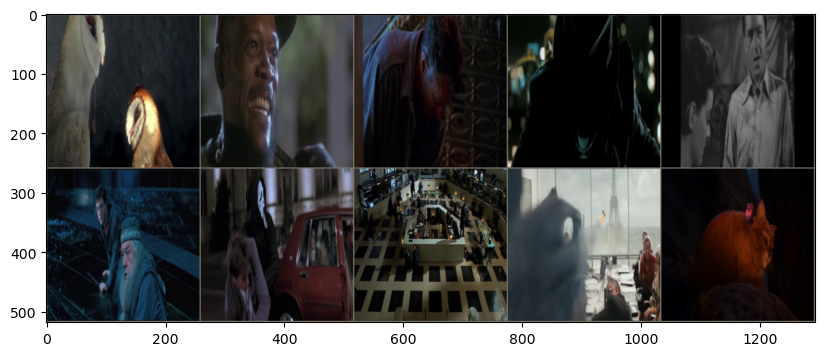

In [4]:
# Displaying the data
for images, labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Category:', *np.array([list(category_names)[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

print()

In [5]:
# Choosing the model
model = models.alexnet(pretrained=True)
model

c:\Users\krzys\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\krzys\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
model.classifier[6] = nn.Linear(4096, len(category_names))
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
# Define loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# By default, everything is loaded to cpu
gpumodel = model.cuda() # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

False

In [9]:
# Train the model
import time
start_time = time.time()

epochs = 10

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Bring data over the device of choice
        X_train = X_train.to('cuda')
        y_train = y_train.to('cuda')
        
        # Apply the model
        y_pred = gpumodel(X_train)
        loss = criterion(y_pred, y_train)
        
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
    
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4}  loss: {loss.item():10.8f}  accuracy: {trn_corr.item()*100/(10*b):7.3f}%')  
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break
            
            # Bring data over the device of choice
            X_test = X_test.to('cuda')
            y_test = y_test.to('cuda')

            # Apply the model
            y_val = gpumodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed


epoch:  0  batch:  200  loss: 2.13641930  accuracy:  29.350%
epoch:  0  batch:  400  loss: 1.60107732  accuracy:  30.300%
epoch:  1  batch:  200  loss: 1.63023353  accuracy:  32.800%
epoch:  1  batch:  400  loss: 2.46457148  accuracy:  30.650%
epoch:  2  batch:  200  loss: 1.90571594  accuracy:  30.650%
epoch:  2  batch:  400  loss: 1.71254659  accuracy:  30.925%
epoch:  3  batch:  200  loss: 2.22272754  accuracy:  31.700%
epoch:  3  batch:  400  loss: 1.85560250  accuracy:  31.775%
epoch:  4  batch:  200  loss: 2.76388741  accuracy:  31.300%
epoch:  4  batch:  400  loss: 1.95348001  accuracy:  31.325%
epoch:  5  batch:  200  loss: 2.20488429  accuracy:  29.900%
epoch:  5  batch:  400  loss: 1.76825786  accuracy:  30.325%
epoch:  6  batch:  200  loss: 1.83137679  accuracy:  29.950%
epoch:  6  batch:  400  loss: 1.71146703  accuracy:  31.450%
epoch:  7  batch:  200  loss: 2.09776545  accuracy:  30.450%
epoch:  7  batch:  400  loss: 2.13058782  accuracy:  30.925%
epoch:  8  batch:  200  

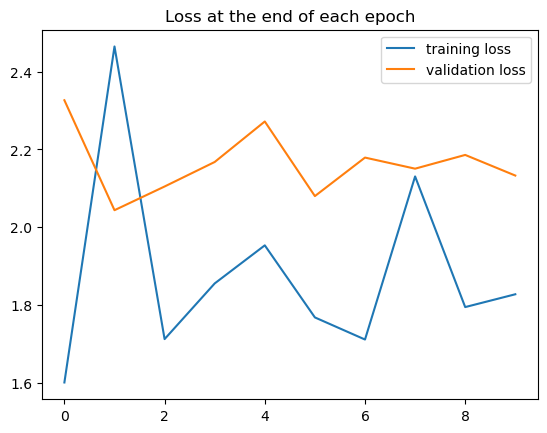

In [20]:
# Evaluate model performance
train_losses_cpu = [t.cpu().detach().numpy() for t in train_losses]
test_losses_cpu = [t.cpu().detach().numpy() for t in test_losses]

plt.plot(train_losses_cpu, label='training loss')
plt.plot(test_losses_cpu, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

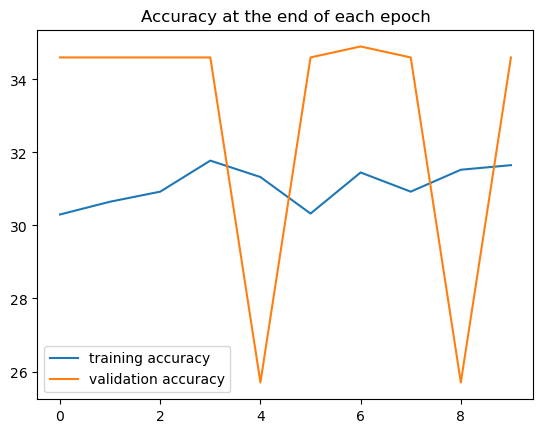

In [24]:
train_correct_cpu = [t.cpu().detach().numpy() for t in train_correct]
test_correct_cpu = [t.cpu().detach().numpy() for t in test_correct]

plt.plot([t/40 for t in train_correct_cpu], label='training accuracy')
plt.plot([t/10 for t in test_correct_cpu], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [26]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/1000:.3f}%')

[tensor(346, device='cuda:0'), tensor(346, device='cuda:0'), tensor(346, device='cuda:0'), tensor(346, device='cuda:0'), tensor(257, device='cuda:0'), tensor(346, device='cuda:0'), tensor(349, device='cuda:0'), tensor(346, device='cuda:0'), tensor(257, device='cuda:0'), tensor(346, device='cuda:0')]
Test accuracy: 34.600%


In [36]:
print('train_losses: ', [t.cpu().detach().numpy().item() for t in train_losses])
print('train_accuracy: ', [t.cpu().detach().numpy().item()/40 for t in train_correct])
print('test_losses: ', [t.cpu().detach().numpy().item() for t in test_losses])
print('test_accuracy: ', [t.cpu().detach().numpy().item()/40 for t in test_correct])

train_losses:  [1.6010773181915283, 2.464571475982666, 1.7125465869903564, 1.855602502822876, 1.9534800052642822, 1.7682578563690186, 1.7114670276641846, 2.1305878162384033, 1.7948452234268188, 1.827773094177246]
train_accuracy:  [30.3, 30.65, 30.925, 31.775, 31.325, 30.325, 31.45, 30.925, 31.525, 31.65]
test_losses:  [2.3264033794403076, 2.043823719024658, 2.104731798171997, 2.167724132537842, 2.271791934967041, 2.0800864696502686, 2.179051160812378, 2.150536060333252, 2.185875415802002, 2.132854461669922]
test_accuracy:  [8.65, 8.65, 8.65, 8.65, 6.425, 8.65, 8.725, 8.65, 6.425, 8.65]
